## εのバランスを崩す

εのバランスを崩して，今回構築したメカニズムが機能していることを確認する．\
ノイズの種類として，中度のプライバシーレベルと高度なプライバシーレベルの2つでそれぞれ確認する．\
この際の効用関数の比は2:1のものを使用している．
### 中度のプライバシーレベル
1. 正しいノイズ（ε_xy = 0.6, ε_t = 2.4）
2. XYに厳しいノイズ(ε_xy = 0.001, ε_t = 4.476)
3. Tに厳しいノイズ（ε_xy = 1.119, ε_t = 0.004）

In [1]:
# モジュールの導入
import numpy as np
from scipy.special import lambertw as LW
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import statistics

In [2]:
# ユークリッド距離を返す関数
def distance(Noise_x, Noise_y, POI_x, POI_y):
    return np.sqrt( (Noise_x - POI_x)**2 + (Noise_y - POI_y)**2 )

In [3]:
# POI検索関数
def PointOfInterest(total_true, total_false, total_num, loc_info, POI_info,
                   x_noise, y_noise, t_noise, moving_speed):
    for times in range(total_num):
        t_sum = loc_info[2] + t_noise[times] + (distance(x_noise[0][times], y_noise[0][times],
                                                        POI_info[0], POI_info[1]) 
                                                / moving_speed)
        if (POI_info[2] > t_sum):
            total_true += 1
        else:
            total_false += 1
    return total_true, total_false

In [4]:
# 入力データ
# 実際の位置情報データ（時空間(x,y,t)）
real_loc_info = [0, 0, 12]

# POIデータ(時空間(x,y,t=閉館時刻))
POI_loc_info = [[0, 0,17],[4, 0,17],[8, 0,17],
                [12,0,17],[16,0,17],[20,0,17],
                [24,0,17],[28,0,17],[32,0,17]]

# 移動速度
verocity = 4.0

# ランダム化した点の総数
total_num_points = 10000

# EXメカニズムの効用関数の比 pp : 1
pp = 10

In [5]:
# グラフ描画の際の横軸を用意する
time_list = []
for i in range(len(POI_loc_info)):
    time_list.append(distance(real_loc_info[0], real_loc_info[1], 
                              POI_loc_info[i][0], POI_loc_info[i][1]) 
                     / verocity)
time_list

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

#### 正しいノイズ（ε_xy = 0.6, ε_t = 2.4）

In [6]:
# POI検索プログラムによる出力（到達できるか否かを表す）
poi_true_total_0  = 0
poi_false_total_0 = 0
make_graph0       = []
path_w_0 = 'right_Balance_Noise0.txt'

In [7]:
# ノイズを付与した座標を格納するためのリスト
zx_list_0 = []
zy_list_0 = []
# ノイズを付与した時刻を格納するためのリスト
zt_list_0 = []

# POIの検索結果を格納するためのリスト
POI_result_list_0 = []
POI_True_list_0   = []
POI_False_list_0  = []

# epsilonの値の定義
epsilon_z_0 = 0.6
epsilon_t_0 = epsilon_z_0 * verocity

In [8]:
# ノイズを生成する
# thetaを[0:2π)の範囲で一様分布にしたがって生成する
theta = np.random.uniform(0,2*np.pi, total_num_points)

# [0:1)の範囲で一様分布に従ったランダぷのいずを生成する
p_z_0 = np.random.uniform(0,1,total_num_points)
p_t_0 = np.random.uniform(0,1,total_num_points)

for l in range(len(POI_loc_info)):
    for i in range(100):
        # 100回繰り返した平均を取得する
        # PLノイズを付与
        W = LW( ((p_z_0 - 1) / np.e), k = -1 )
        r = ( -1 / epsilon_z_0 ) * ( W + 1 )
        
        zx = real_loc_info[0] + r * np.cos(theta)
        zx_list_0.append(np.array(zx))
        zy = real_loc_info[1] + r * np.sin(theta)
        zy_list_0.append(np.array(zy))
        
        # EXノイズを付与
        for j in range(total_num_points):
            if p_t_0[j] <= (pp/(pp+1)):
                zt_list_0.append( ((2*pp)/epsilon_t_0) * np.log( ((pp+1)*p_t_0[j]) / pp ))
            else:
                zt_list_0.append( (2/epsilon_t_0) * np.log( (1 / ((pp+1)*(1-p_t_0[j]))) ))
        POI_result_list_0.append(PointOfInterest(
            poi_true_total_0, poi_false_total_0, total_num_points,
        real_loc_info, POI_loc_info[l], zx_list_0, zy_list_0, zt_list_0,
        verocity))
        
        # ノイズを付与した値を格納するためのリストをクリアする
        zx_list_0 = []
        zy_list_0 = []
        zt_list_0 = []
        
    for k in range(100):
        POI_True_list_0.append(POI_result_list_0[k][0])
        POI_False_list_0.append(POI_result_list_0[k][1])
        
    true_mean = statistics.mean(POI_True_list_0)
    false_mean = statistics.mean(POI_False_list_0)
    make_graph0.append(true_mean)
    with open(path_w_0, mode='a') as f:
        f.write("POI -> ")
        f.write(str(POI_loc_info[l]))
        f.write(", epsilon(xy) = ")
        f.write(str(epsilon_z_0))
        f.write(",epsilon(t) = ")
        f.write(str(epsilon_t_0))
        f.write("の時\n")
        f.write("trueの平均値 = ")
        f.write(str(true_mean))
        f.write(", falseの平均値 = ")
        f.write(str(false_mean))
        f.write("\n")
        
    # POIに関連するリストのクリア
    POI_result_list_0 = []
    POI_True_list_0   = []
    POI_False_list_0  = []
    poi_true_0 = 0
    poi_false_0 = 0
    print("Number "+str(l+1)+" is Done")
print("Finish")

Number 1 is Done
Number 2 is Done
Number 3 is Done
Number 4 is Done
Number 5 is Done
Number 6 is Done
Number 7 is Done
Number 8 is Done
Number 9 is Done
Finish


#### XYに厳しいノイズ(ε_xy = 0.001, ε_t = 4.476)

In [9]:
# POI検索プログラムによる出力（到達できるか否かを表す）
poi_true_total_1  = 0
poi_false_total_1 = 0
make_graph1       = []
# path_w_1 = 'right_Balance_Noise1.txt'

In [10]:
# ノイズを付与した座標を格納するためのリスト
zx_list_1 = []
zy_list_1 = []
# ノイズを付与した時刻を格納するためのリスト
zt_list_1 = []

# POIの検索結果を格納するためのリスト
POI_result_list_1 = []
POI_True_list_1   = []
POI_False_list_1  = []

# epsilonの値の定義
epsilon_z_1 = 0.001
epsilon_t_1 = 4.476

In [11]:
# ノイズを生成する
# thetaを[0:2π)の範囲で一様分布にしたがって生成する
theta = np.random.uniform(0,2*np.pi, total_num_points)

# [0:1)の範囲で一様分布に従ったランダぷのいずを生成する
p_z_1 = np.random.uniform(0,1,total_num_points)
p_t_1 = np.random.uniform(0,1,total_num_points)

for l in range(len(POI_loc_info)):
    for i in range(100):
        # 100回繰り返した平均を取得する
        # PLノイズを付与
        W = LW( ((p_z_1 - 1) / np.e), k = -1 )
        r = ( -1 / epsilon_z_1 ) * ( W + 1 )
        
        zx = real_loc_info[0] + r * np.cos(theta)
        zx_list_1.append(np.array(zx))
        zy = real_loc_info[1] + r * np.sin(theta)
        zy_list_1.append(np.array(zy))
        
        # EXノイズを付与
        for j in range(total_num_points):
            if p_t_1[j] <= (pp/(pp+1)):
                zt_list_1.append( ((2*pp)/epsilon_t_1) * np.log( ((pp+1)*p_t_1[j]) / pp ))
            else:
                zt_list_1.append( (2/epsilon_t_1) * np.log( (1 / ((pp+1)*(1-p_t_1[j]))) ))
        POI_result_list_1.append(PointOfInterest(
            poi_true_total_1, poi_false_total_1, total_num_points,
        real_loc_info, POI_loc_info[l], zx_list_1, zy_list_1, zt_list_1,
        verocity))
        
        # ノイズを付与した値を格納するためのリストをクリアする
        zx_list_1 = []
        zy_list_1 = []
        zt_list_1 = []
        
    for k in range(100):
        POI_True_list_1.append(POI_result_list_1[k][0])
        POI_False_list_1.append(POI_result_list_1[k][1])
        
    true_mean = statistics.mean(POI_True_list_1)
    false_mean = statistics.mean(POI_False_list_1)
    make_graph1.append(true_mean)
    """
    with open(path_w_1, mode='a') as f:
        f.write("POI -> ")
        f.write(str(POI_loc_info[l]))
        f.write(", epsilon(xy) = ")
        f.write(str(epsilon_z_1))
        f.write(",epsilon(t) = ")
        f.write(str(epsilon_t_1))
        f.write("の時\n")
        f.write("trueの平均値 = ")
        f.write(str(true_mean))
        f.write(", falseの平均値 = ")
        f.write(str(false_mean))
        f.write("\n")
    """
    # POIに関連するリストのクリア
    POI_result_list_1 = []
    POI_True_list_1   = []
    POI_False_list_1  = []
    poi_true_1  = 0
    poi_false_1 = 0
    print("Number "+str(l+1)+" is Done")
print("Finish")

Number 1 is Done
Number 2 is Done
Number 3 is Done
Number 4 is Done
Number 5 is Done
Number 6 is Done
Number 7 is Done
Number 8 is Done
Number 9 is Done
Finish


#### Tに厳しいノイズ（ε_xy = 1.119, ε_t = 0.004）

In [12]:
# POI検索プログラムによる出力（到達できるか否かを表す）
poi_true_total_2  = 0
poi_false_total_2 = 0
make_graph2       = []
# path_w_2 = 'right_Balance_Noise2.txt'

In [13]:
# ノイズを付与した座標を格納するためのリスト
zx_list_2 = []
zy_list_2 = []
# ノイズを付与した時刻を格納するためのリスト
zt_list_2 = []

# POIの検索結果を格納するためのリスト
POI_result_list_2 = []
POI_True_list_2   = []
POI_False_list_2  = []

# epsilonの値の定義
epsilon_z_2 = 1.119
epsilon_t_2 = 0.004

In [14]:
# ノイズを生成する
# thetaを[0:2π)の範囲で一様分布にしたがって生成する
theta = np.random.uniform(0,2*np.pi, total_num_points)

# [0:1)の範囲で一様分布に従ったランダぷのいずを生成する
p_z_2 = np.random.uniform(0,1,total_num_points)
p_t_2 = np.random.uniform(0,1,total_num_points)

for l in range(len(POI_loc_info)):
    for i in range(100):
        # 100回繰り返した平均を取得する
        # PLノイズを付与
        W = LW( ((p_z_2 - 1) / np.e), k = -1 )
        r = ( -1 / epsilon_z_2 ) * ( W + 1 )
        
        zx = real_loc_info[0] + r * np.cos(theta)
        zx_list_2.append(np.array(zx))
        zy = real_loc_info[1] + r * np.sin(theta)
        zy_list_2.append(np.array(zy))
        
        # EXノイズを付与
        for j in range(total_num_points):
            if p_t_2[j] <= (pp/(pp+1)):
                zt_list_2.append( ((2*pp)/epsilon_t_2) * np.log( ((pp+1)*p_t_2[j]) / pp ))
            else:
                zt_list_2.append( (2/epsilon_t_2) * np.log( (1 / ((pp+1)*(1-p_t_2[j]))) ))
        POI_result_list_2.append(PointOfInterest(
            poi_true_total_2, poi_false_total_2, total_num_points,
        real_loc_info, POI_loc_info[l], zx_list_2, zy_list_2, zt_list_2,
        verocity))
        
        # ノイズを付与した値を格納するためのリストをクリアする
        zx_list_2 = []
        zy_list_2 = []
        zt_list_2 = []
        
    for k in range(100):
        POI_True_list_2.append(POI_result_list_2[k][0])
        POI_False_list_2.append(POI_result_list_2[k][1])
        
    true_mean = statistics.mean(POI_True_list_2)
    false_mean = statistics.mean(POI_False_list_2)
    make_graph2.append(true_mean)
    """
    with open(path_w_2, mode='a') as f:
        f.write("POI -> ")
        f.write(str(POI_loc_info[l]))
        f.write(", epsilon(xy) = ")
        f.write(str(epsilon_z_2))
        f.write(",epsilon(t) = ")
        f.write(str(epsilon_t_2))
        f.write("の時\n")
        f.write("trueの平均値 = ")
        f.write(str(true_mean))
        f.write(", falseの平均値 = ")
        f.write(str(false_mean))
        f.write("\n")
    """
    # POIに関連するリストのクリア
    POI_result_list_2 = []
    POI_True_list_2   = []
    POI_False_list_2  = []
    poi_true_2  = 0
    poi_false_2 = 0
    print("Number "+str(l+1)+" is Done")
print("Finish")

Number 1 is Done
Number 2 is Done
Number 3 is Done
Number 4 is Done
Number 5 is Done
Number 6 is Done
Number 7 is Done
Number 8 is Done
Number 9 is Done
Finish


### consideration

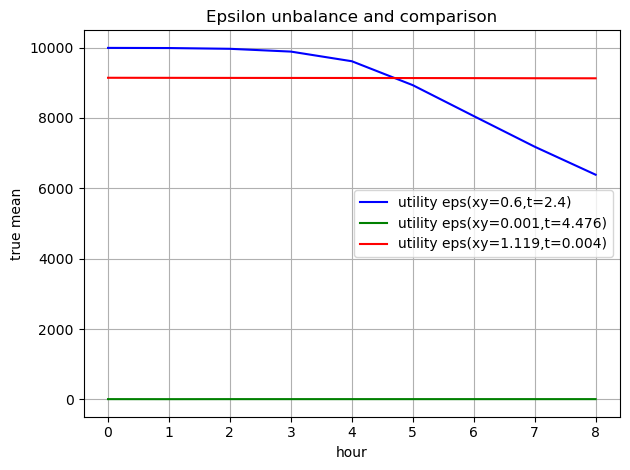

In [15]:
fig, ax = plt.subplots()

c0,c1,c2 = "blue","green","red"     # 各プロットの色
l0,l1,l2 = "utility eps(xy=0.6,t=2.4)","utility eps(xy=0.001,t=4.476)","utility eps(xy=1.119,t=0.004)"   # 各ラベル

ax.set_xlabel('hour')  # x軸ラベル
ax.set_ylabel('true mean')  # y軸ラベル
ax.set_title(r'Epsilon unbalance and comparison') # グラフタイトル
# ax.set_aspect('equal') # スケールを揃える
ax.grid()            # 罫線
#ax.set_xlim([-10, 10]) # x方向の描画範囲を指定
#ax.set_ylim([0, 1])    # y方向の描画範囲を指定
ax.plot(time_list, make_graph0, color=c0, label=l0)
ax.plot(time_list, make_graph1, color=c1, label=l1)
ax.plot(time_list, make_graph2, color=c2, label=l2)
ax.legend(loc=0)    # 凡例
fig.tight_layout()  # レイアウトの設定
plt.savefig('EpsilonUnbalance-extreme_.png') # 画像の保存
plt.show()